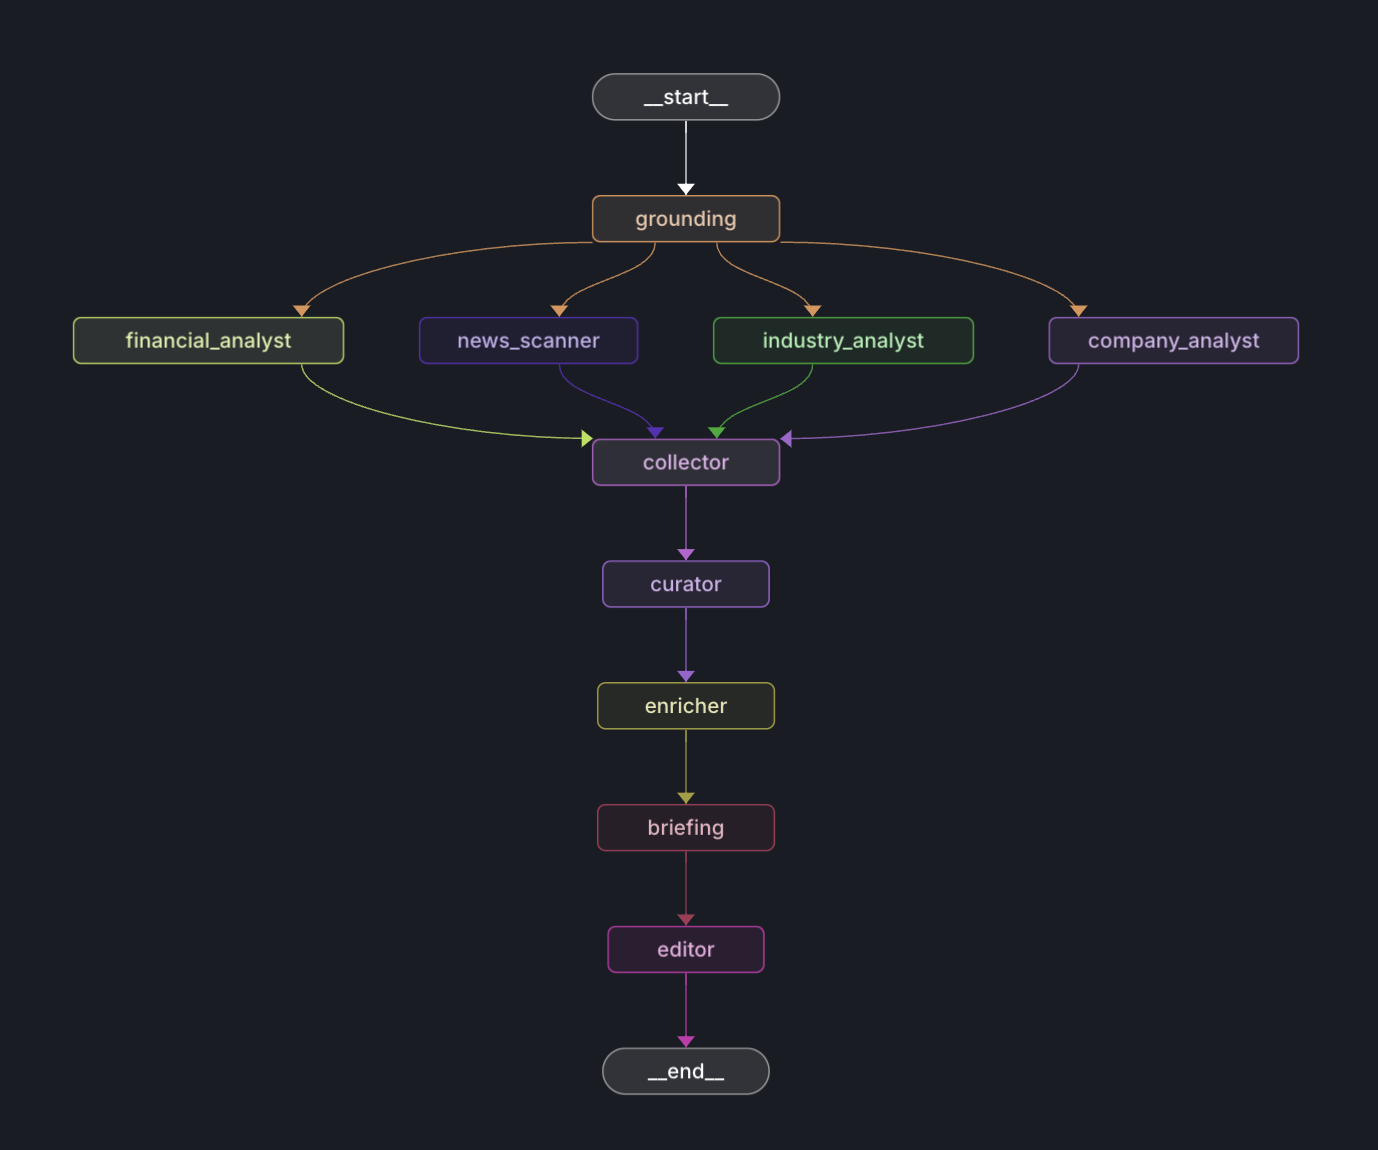

In [2]:
import os
from dotenv import load_dotenv
load_dotenv() 

True

In [185]:
from langchain_core.messages import AIMessage
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from datetime import datetime
import logging
from urllib.parse import urljoin, urlparse

In [255]:
from typing import Any, Dict, List, Union

In [5]:
# Initialize Tavily client
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

In [41]:
company = "Turing"
url = "https://www.turing.com/"
hq = 'Palo Alto, California'
industry = "AI"

# Grounding

# Financial Analyst

In [33]:
message = f"🎯 Initiating research for {company}."

site_scrape = {}

if url:
    message += f"\n🌐 Analyzing company website: {url}"

    try:
        extraction = tavily_client.extract(url, extract_depth="basic")
        raw_contents = []

        for item in extraction.get("results", []):
            content = item.get("raw_content")
            if content:
                raw_contents.append(content)

        if raw_contents:
            site_scrape = {
                "title": company,
                "raw_content": "\n\n".join(raw_contents)
            }
            message += "\n✅ Successfully extracted content from website."
        else:
            message += "\n⚠️ No content found on website."
    except Exception as e:
        message += f"\n⚠️ Error extracting content: {str(e)}"
        # You can choose to log or raise the error depending on your system
else:
    message += "\n⏩ No company URL provided, skipping website analysis."

# Add this message to state
messages = []
messages.append(AIMessage(content=message))

# Two values to update: messages, site_scrape


In [42]:
# Generate financial queries using OpenAI
prompt = f"""
Generate queries on the financial analysis of {company} in the {industry} industry such as:
- Fundraising history and valuation
- Financial statements and key metrics
- Revenue and profit sources

Important Guidelines:
- Focus ONLY on {company}-specific information
- Make queries very brief and to the point
- Provide exactly 4 search queries (one per line), with no hyphens or dashes
- DO NOT make assumptions about the industry - use only the provided industry information
"""

In [49]:
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0,
    max_tokens=512,
)
messages=[
        {"role": "system", "content": f"You are researching {company} in the {industry} industry."},
        {"role": "user", "content": prompt}
]
ai_msg = llm.invoke(messages)
print(ai_msg.content)

Turing fundraising history and valuation  
Turing financial statements and key metrics  
Turing revenue sources in AI industry  
Turing profit sources in AI industry


In [56]:
queries_text = ai_msg.content.strip()
queries = [line.strip() for line in queries_text.split("\n") if line.strip()]

In [57]:
queries

['Turing fundraising history and valuation',
 'Turing financial statements and key metrics',
 'Turing revenue sources in AI industry',
 'Turing profit sources in AI industry']

In [58]:
content="🔍 Subqueries for financial analysis:\n" + "\n".join([f"• {q}" for q in queries])

In [60]:
print(content)

🔍 Subqueries for financial analysis:
• Turing fundraising history and valuation
• Turing financial statements and key metrics
• Turing revenue sources in AI industry
• Turing profit sources in AI industry


In [61]:
# Search documents using Tavily
financial_data = {}
for query in queries:
    results = tavily_client.search(query, search_depth="basic", max_results=5)
    for result in results.get("results", []):
        url = result.get("url")
        if not url or not result.get("content"):
            continue
        financial_data[url] = {
            "title": result.get("title", ""),
            "content": result.get("content", ""),
            "query": query,
            "url": url,
            "source": "web_search",
            "score": result.get("score", 0.0)
        }

In [63]:
len(financial_data)

17

# Company Analyzer

In [70]:
# Generate search queries using LLM
prompt = f"""
Generate queries on the company fundamentals of {company} in the {industry} industry such as:
- Core products and services
- Company history and milestones
- Leadership team
- Business model and strategy
"""

messages=[
        {"role": "system", "content": f"You are researching {company} in the {industry} industry."},
        {"role": "user", "content": prompt}
]
ai_msg = llm.invoke(messages)
print(ai_msg.content)

Here are some queries you can use to research the company fundamentals of Turing in the AI industry:

1. What are the core products and services offered by Turing in the AI industry?
2. How does Turing leverage AI technology in its product offerings?
3. What is the history and founding story of Turing?
4. What major milestones and achievements has Turing reached since its inception?
5. Who are the key members of Turing’s leadership team and what are their backgrounds?
6. What is Turing’s business model in the AI sector?
7. How does Turing generate revenue from its AI products and services?
8. What strategic initiatives has Turing undertaken to grow its presence in the AI industry?
9. How does Turing differentiate itself from competitors in the AI market?
10. What partnerships or collaborations has Turing established to enhance its AI capabilities?
11. How has Turing evolved its product roadmap over time in response to AI industry trends?
12. What are Turing’s long-term goals and vision

# Utils

In [124]:
import logging
import re
from typing import Any, Dict, List, Tuple
from urllib.parse import urlparse

In [127]:
def clean_title(title: str) -> str:
    """Clean up a title by removing dates, trailing periods or quotes, and truncating if needed."""
    if not title:
        return ""
    
    original_title = title
    
    title = title.strip().rstrip('.').strip('"\'')
    title = re.sub(r'^\d{4}[-\s]*\d{1,2}[-\s]*\d{1,2}[-\s]*', '', title)
    title = title.strip('- ').strip()
    
    # If title became empty after cleaning, return empty string
    if not title:
        logging.warning(f"Title became empty after cleaning: '{original_title}'")
        return ""
    
    # Log if we made changes to the title
    if title != original_title:
        logging.info(f"Cleaned title from '{original_title}' to '{title}'")
    
    return title

In [195]:
import logging
import re
from typing import Any, Dict, List, Tuple
from urllib.parse import urlparse

logger = logging.getLogger(__name__)

def extract_domain_name(url: str) -> str:
    """Extract a readable website name from a URL."""
    try:
        # Remove protocol and www
        domain = url.lower()
        for prefix in ['https://', 'http://', 'www.']:
            if domain.startswith(prefix):
                domain = domain[len(prefix):]
        
        # Get the main domain part (before first slash or query)
        domain = domain.split('/')[0].split('?')[0]
        
        # Extract the main part (e.g., 'tavily' from 'tavily.com')
        parts = domain.split('.')
        if len(parts) >= 2:
            main_name = parts[0]
            # Capitalize the name
            return main_name.capitalize()
        return domain.capitalize()
    except Exception as e:
        logger.error(f"Error extracting domain name from {url}: {e}")
        return "Website"

def extract_title_from_url_path(url: str) -> str:
    """Extract a meaningful title from the URL path."""
    try:
        # Remove protocol, www, and domain
        path = url.lower()
        for prefix in ['https://', 'http://', 'www.']:
            if path.startswith(prefix):
                path = path[len(prefix):]
        
        # Remove domain
        if '/' in path:
            path = path.split('/', 1)[1]
        else:
            path = ""
            
        # Clean up the path to create a title
        if path:
            # Remove file extensions and query parameters
            path = path.split('?')[0].split('#')[0]
            if path.endswith('/'):
                path = path[:-1]
                
            # Replace hyphens and underscores with spaces
            path = path.replace('-', ' ').replace('_', ' ').replace('/', ' - ')
            
            # Capitalize words
            title = ' '.join(word.capitalize() for word in path.split())
            
            # If title is still too long, truncate it
            if len(title) > 100:
                title = title[:97] + "..."
                
            return title
        return ""
    except Exception as e:
        logger.error(f"Error extracting title from URL path: {e}")
        return ""

def clean_title(title: str) -> str:
    """Clean up a title by removing dates, trailing periods or quotes, and truncating if needed."""
    if not title:
        return ""
    
    original_title = title
    
    title = title.strip().rstrip('.').strip('"\'')
    title = re.sub(r'^\d{4}[-\s]*\d{1,2}[-\s]*\d{1,2}[-\s]*', '', title)
    title = title.strip('- ').strip()
    
    # If title became empty after cleaning, return empty string
    if not title:
        logger.warning(f"Title became empty after cleaning: '{original_title}'")
        return ""
    
    # Log if we made changes to the title
    if title != original_title:
        logger.info(f"Cleaned title from '{original_title}' to '{title}'")
    
    return title

def normalize_url(url: str) -> str:
    """Normalize a URL by removing query parameters and fragments."""
    try:
        if not url:
            return ""
            
        # Ensure URL has a scheme
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
            
        parsed = urlparse(url)
        normalized_url = parsed._replace(query='', fragment='').geturl().rstrip('/')
        
        return normalized_url
    except Exception as e:
        logger.error(f"Error normalizing URL {url}: {e}")
        return url

def extract_website_name_from_domain(domain: str) -> str:
    """Extract a readable website name from a domain."""
    if domain.startswith('www.'):
        domain = domain[4:]  # Remove www. prefix
    
    # Extract the main part (e.g., 'tavily' from 'tavily.com')
    website_name = domain.split('.')[0].capitalize()
    
    # Handle special cases
    if website_name == "Com":
        # Try to get a better name from the second part
        parts = domain.split('.')
        if len(parts) > 1:
            website_name = parts[0].capitalize()
    
    return website_name

def process_references_from_search_results(state: Dict[str, Any]) -> Tuple[List[str], Dict[str, str], Dict[str, Dict[str, Any]]]:
    """Process references from search results and return top references, titles, and info."""
    all_top_references = []
    
    # Collect references with scores from all data types
    data_types = ['curated_company_data', 'curated_industry_data', 'curated_financial_data', 'curated_news_data']
    
    # Log the start of reference processing
    logger.info("Starting to process references from search results")
    
    for data_type in data_types:
        if curated_data := state.get(data_type, {}):
            for url, doc in curated_data.items():
                try:
                    # Ensure we have a valid score
                    if 'evaluation' in doc and 'overall_score' in doc['evaluation']:
                        score = float(doc['evaluation']['overall_score'])
                    else:
                        # Fallback to raw score if available
                        score = float(doc.get('score', 0))
                    
                    logger.info(f"Found reference in {data_type}: URL={url}, Score={score:.4f}")
                    all_top_references.append((url, score))
                except (KeyError, ValueError, TypeError) as e:
                    logger.warning(f"Error processing score for {url} in {data_type}: {e}")
                    continue
    
    logger.info(f"Collected a total of {len(all_top_references)} references before deduplication")
    
    # Sort references by score in descending order
    all_top_references.sort(key=lambda x: float(x[1]), reverse=True)
    
    # Log top 20 references before deduplication to verify sorting
    logger.info("Top 20 references by score before deduplication:")
    for i, (url, score) in enumerate(all_top_references[:20]):
        logger.info(f"{i+1}. Score: {score:.4f} - URL: {url}")
    
    # Use a set to store unique URLs, keeping only the highest scored version of each URL
    seen_urls = set()
    unique_references = []
    reference_titles = {}  # Store titles for references
    reference_info = {}  # Store additional information for MLA-style references
    
    for url, score in all_top_references:
        # Skip if URL is not valid
        if not url or not url.startswith(('http://', 'https://')):
            logger.info(f"Skipping invalid URL: {url}")
            continue

        # Normalize URL
        normalized_url = normalize_url(url)
        
        if normalized_url not in seen_urls:
            seen_urls.add(normalized_url)
            unique_references.append((normalized_url, score))
            
            # Extract domain name for website citation
            parsed = urlparse(url)
            domain = parsed.netloc
            
            # Find and store the title and other info for this URL
            title = None
            website_name = None
            
            # Look for the document info in all data types
            for data_type in data_types:
                if not title and (curated_data := state.get(data_type, {})):
                    for doc in curated_data.values():
                        if doc.get('url') == url:
                            title = doc.get('title', '')
                            if title:
                                # Clean up the title
                                title = clean_title(title)
                                if title and title.strip() and title != url:
                                    reference_titles[normalized_url] = title
                                    logger.info(f"Found title for URL {url}: '{title}'")
                                    break
            
            # If no title was found, log it
            if not title:
                logger.info(f"No valid title found for URL {url}")
            
            # Extract a better website name from the domain
            website_name = extract_website_name_from_domain(domain)
            
            # Store additional information for MLA citation
            reference_info[normalized_url] = {
                'title': title or '',
                'domain': domain,
                'website': website_name,
                'url': normalized_url,
                'score': score
            }
            logger.info(f"Stored reference info for {normalized_url} with score {score:.4f}")
    
    # Sort unique references by score again to ensure proper ordering
    unique_references.sort(key=lambda x: float(x[1]), reverse=True)
    
    # Log unique references by score to verify sorting
    logger.info(f"Found {len(unique_references)} unique references after deduplication")
    logger.info("Unique references by score (sorted):")
    for i, (url, score) in enumerate(unique_references):
        logger.info(f"{i+1}. Score: {score:.4f} - URL: {url}")
    
    # Take exactly 10 unique references (or all if less than 10)
    top_references = unique_references[:10]
    top_reference_urls = [url for url, _ in top_references]
    
    # Log final top 10 references
    logger.info(f"Final top {len(top_reference_urls)} references selected:")
    for i, url in enumerate(top_reference_urls):
        score = next((s for u, s in unique_references if u == url), 0)
        logger.info(f"{i+1}. Score: {score:.4f} - URL: {url}")
    
    return top_reference_urls, reference_titles, reference_info

def format_reference_for_markdown(reference_entry: Dict[str, Any]) -> str:
    """Format a reference entry for markdown output."""
    website = reference_entry.get('website', '')
    title = reference_entry.get('title', '')
    url = reference_entry.get('url', '')
    
    # Ensure we have a website name
    if not website or website.strip() == "":
        website = extract_domain_name(url)
    
    # Ensure we have a title
    if not title or title.strip() == "" or title == url:
        # Try to extract a meaningful title from the URL
        title = extract_title_from_url_path(url)
        
        # If still no title, use default format
        if not title:
            title = f"Information from {website}"
    
    # Format: * Website. "Title." URL
    return f"* {website}. \"{title}.\" {url}"

def extract_link_info(line: str) -> tuple[str, str]:
    """Extract title and URL from markdown link."""
    try:
        # First clean any JSON artifacts that might interfere with link parsing
        line = re.sub(r'",?\s*"pdf_url":.+$', '', line)
        
        # Check for MLA-style references with website and title before the link
        # Format: * Website. "Title." [URL](URL)
        mla_match = re.match(r'\*?\s*(.*?)\s*\.\s*"(.*?)\."\s*\[(.*?)\]\((.*?)\)', line)
        if mla_match:
            website = clean_title(mla_match.group(1))
            title = clean_title(mla_match.group(2))
            link_text = clean_title(mla_match.group(3))
            url = clean_title(mla_match.group(4))
            
            # If website is empty or just a period, extract from URL
            if not website or website == ".":
                website = extract_domain_name(url)
            
            # Format for PDF: "Website. Title. URL"
            return f"{website}. {title}. {link_text}", url
        
        # Fallback for standard markdown links
        match = re.match(r'\[(.*?)\]\((.*?)\)', line)
        if match:
            title = clean_title(match.group(1))
            url = clean_title(match.group(2))
            # If the title is a URL and matches the URL, just use the URL
            if title.startswith('http') and title == url:
                return url, url
            return title, url
        
        logger.debug(f"No link match found in line: {line}")
        return '', ''
    except Exception as e:
        logger.error(f"Error extracting link info from line: {line}, error: {str(e)}")
        return '', ''

def format_references_section(references: List[str], reference_info: Dict[str, Dict[str, Any]], reference_titles: Dict[str, str]) -> str:
    """Format the references section for the final report."""
    if not references:
        return ""
    
    logger.info(f"Formatting {len(references)} references for the report")
    
    # Create a list of reference entries with all the information needed
    reference_entries = []
    for ref in references:
        info = reference_info.get(ref, {})
        website = info.get('website', '')
        title = info.get('title', '')
        score = info.get('score', 0)
        
        # If title is not in reference_info, try to get it from reference_titles
        if not title or title.strip() == "":
            title = reference_titles.get(ref, '')
            logger.info(f"Using title from reference_titles for {ref}: '{title}'")
        
        domain = info.get('domain', '')
        
        # If we don't have a title, use the URL
        if not title or title.strip() == "" or title == ref:
            title = ref
            logger.info(f"No title found for {ref}, using URL as title")
        
        # If we don't have a website name, extract it from the URL
        if not website or website.strip() == "":
            website = extract_domain_name(ref)
            logger.info(f"No website name found for {ref}, extracted: {website}")
        
        # Create a reference entry with all information
        entry = {
            'website': website,
            'title': title,
            'url': ref,
            'domain': domain,
            'score': score
        }
        logger.info(f"Created reference entry: {entry}")
        reference_entries.append(entry)
    
    # Keep references in the same order they were provided (which should be by score)
    # This preserves the top 10 scoring order from process_references_from_search_results
    logger.info("Maintaining reference order based on scores")
    
    # Format references in MLA style
    reference_lines = ["\n## References"]
    for entry in reference_entries:
        reference_line = format_reference_for_markdown(entry)
        reference_lines.append(reference_line)
        logger.info(f"Added reference: {reference_line}")
    
    reference_text = "\n".join(reference_lines)
    logger.info(f"Completed references section with {len(reference_entries)} entries")
    
    return reference_text 

# Helper Functions

### Query Generator

In [110]:
# inputs: state, prompt, analyst_type
state = {
    'company' : 'Turing',
    'industry' : 'AI',
    'hq': 'Palo Alto, California',
}
analyst_type = "financial_analyst"
prompt = f"""Generate queries on the financial analysis of {state['company']} in the {state['industry']} industry such as:
        - Fundraising history and valuation
        - Financial statements and key metrics
        - Revenue and profit sources
        """

In [90]:
current_year = datetime.now().year

In [91]:
def _format_query_prompt(prompt, company, hq, year):
    return f"""{prompt}

    Important Guidelines:
    - Focus ONLY on {company}-specific information
    - Make queries very brief and to the point
    - Provide exactly 4 search queries (one per line), with no hyphens or dashes
    - DO NOT make assumptions about the industry - use only the provided industry information"""

In [92]:
print(_format_query_prompt(prompt, state['company'], state['hq'], current_year))

Generate queries on the financial analysis of Turing in the AI industry such as:
        - Fundraising history and valuation
        - Financial statements and key metrics
        - Revenue and profit sources
        

    Important Guidelines:
    - Focus ONLY on Turing-specific information
    - Make queries very brief and to the point
    - Provide exactly 4 search queries (one per line), with no hyphens or dashes
    - DO NOT make assumptions about the industry - use only the provided industry information


In [93]:
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0,
    max_tokens=512,
)
messages=[
            {
                "role": "system",
                "content": f"You are researching {company}, a company in the {industry} industry."
            },
            {
                "role": "user",
                "content": f"""Researching {company} on {datetime.now().strftime("%B %d, %Y")}.
{_format_query_prompt(prompt, company, hq, current_year)}"""
            }
]
ai_msg = llm.invoke(messages)
print(ai_msg.content)

Turing fundraising history and valuation in AI industry  
Turing latest financial statements and key metrics  
Turing revenue sources in AI industry  
Turing profit analysis and margins in AI industry


In [103]:
def generate_queries(state, prompt, analyst_type):
    company = state.get("company", "Unknown Company")
    industry = state.get("industry", "Unknown Industry")
    hq = state.get("hq", "Unknown HQ")
    current_year = datetime.now().year

    llm = ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0,
        max_tokens=512,
    )
    messages=[
                {
                    "role": "system",
                    "content": f"You are researching {company}, a company in the {industry} industry."
                },
                {
                    "role": "user",
                    "content": f"""Researching {company} on {datetime.now().strftime("%B %d, %Y")}.
    {_format_query_prompt(prompt, company, hq, current_year)}"""
                }
    ]
    ai_msg = llm.invoke(messages)
    queries_text = ai_msg.content.strip()
    queries = [line.strip() for line in queries_text.split("\n") if line.strip()]
    queries = queries[:4]
    return queries

In [106]:
queries = generate_queries(state, prompt, analyst_type="temp")
queries

['Turing fundraising history and valuation',
 'Turing latest financial statements and key metrics',
 'Turing revenue sources in AI industry',
 'Turing profit breakdown and financial performance']

### Search Document

In [ ]:
# inputs: state, queries, analyst_type

In [113]:
# Prepare all search parameters upfront
search_params = {
    "search_depth": "basic",
    "include_raw_content": False,
    "max_results": 5
}

if analyst_type == "news_analyst":
    search_params["topic"] = "news"
elif analyst_type == "financial_analyst":
    search_params["topic"] = "finance"

search_params

{'search_depth': 'basic',
 'include_raw_content': False,
 'max_results': 5,
 'topic': 'finance'}

In [114]:
# Create all API calls upfront - direct Tavily client calls without the extra wrapper
search_tasks = [
    tavily_client.search(query, **search_params)
    for query in queries
]

In [120]:
len(search_tasks)

4

In [128]:
# Process results
merged_docs = {}
for query, result in zip(queries, search_tasks):
    for item in result.get("results", []):
        if not item.get("content") or not item.get("url"):
            continue
            
        url = item.get("url")
        title = item.get("title", "")
        
        if title:
            title = clean_title(title)
            if title.lower() == url.lower() or not title.strip():
                title = ""

        merged_docs[url] = {
            "title": title,
            "content": item.get("content", ""),
            "query": query,
            "url": url,
            "source": "web_search",
            "score": item.get("score", 0.0)
        }

In [132]:
len(merged_docs)

16

In [133]:
def search_documents(state, queries, analyst_type):
    # Prepare all search parameters upfront
    search_params = {
        "search_depth": "basic",
        "include_raw_content": False,
        "max_results": 5
    }
    
    if analyst_type == "news_analyst":
        search_params["topic"] = "news"
    elif analyst_type == "financial_analyst":
        search_params["topic"] = "finance"
    
    # Create all API calls upfront - direct Tavily client calls without the extra wrapper
    search_tasks = [
        tavily_client.search(query, **search_params)
        for query in queries
    ]

    # Process results
    merged_docs = {}
    for query, result in zip(queries, search_tasks):
        for item in result.get("results", []):
            if not item.get("content") or not item.get("url"):
                continue
                
            url = item.get("url")
            title = item.get("title", "")
            
            if title:
                title = clean_title(title)
                if title.lower() == url.lower() or not title.strip():
                    title = ""
    
            merged_docs[url] = {
                "title": title,
                "content": item.get("content", ""),
                "query": query,
                "url": url,
                "source": "web_search",
                "score": item.get("score", 0.0)
            }
    return merged_docs

In [135]:
# search_documents(state, queries, analyst_type)

# Grounding

In [141]:
# Initialize Tavily client
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

In [143]:
# input state
state = {
    'company' : 'Turing',
    'industry' : 'AI',
    'hq': 'Palo Alto, California',
    'company_url': 'https://www.turing.com/'
}

In [144]:
company = state.get('company', 'Unknown Company')
site_scrape = {}

In [145]:
if url := state.get('company_url'):
    site_extraction = tavily_client.extract(url, extract_depth="basic")
    raw_contents = []
    for item in site_extraction.get("results", []):
        if content := item.get("raw_content"):
            raw_contents.append(content)
    
    if raw_contents:
        site_scrape = {
            'title': company,
            'raw_content': "\n\n".join(raw_contents)
        }

In [148]:
site_scrape.keys()

dict_keys(['title', 'raw_content'])

In [150]:
state['site_scrape'] = site_scrape

# FinancialAnalyst

In [149]:
# input: state
analyst_type = "financial_analyzer"

prompt = f"""Generate queries on the financial analysis of {state['company']} in the {state['industry']} industry such as:
        - Fundraising history and valuation
        - Financial statements and key metrics
        - Revenue and profit sources
        """

In [140]:
queries = generate_queries(state, prompt, analyst_type)
queries

['Turing fundraising history and valuation in AI',
 'Turing latest financial statements and key metrics',
 'Turing revenue sources in AI industry',
 'Turing profit breakdown and financial performance']

In [151]:
# Process site scrape data
financial_data = {}
if site_scrape := state.get('site_scrape'):
    company_url = state.get('company_url', 'company-website')
    financial_data[company_url] = {
        'title': state.get('company', 'Unknown Company'),
        'raw_content': site_scrape,
        'query': f'Financial information on {company}'
    }

In [155]:
for query in queries:
    documents = search_documents(state, [query], analyst_type)
    for url, doc in documents.items():
        doc['query'] = query
        financial_data[url] = doc

In [157]:
state['financial_data'] = financial_data

# CompanyAnalyzer

In [162]:
analyst_type = "company_analyzer"

company = state.get('company', 'Unknown Company')
industry = state.get('industry')
prompt = f"""Generate queries on the company fundamentals of {company} in the {industry} industry such as:
- Core products and services
- Company history and milestones
- Leadership team
- Business model and strategy
"""

In [165]:
queries = generate_queries(state, prompt, analyst_type)

In [166]:
queries

['Turing core products and services in AI',
 'Turing company history and key milestones',
 'Turing leadership team members and roles',
 'Turing business model and growth strategy']

In [168]:
company_data = {}
        
# If we have site_scrape data, include it first
if site_scrape := state.get('site_scrape'):
    company_url = state.get('company_url', 'company-website')
    company_data[company_url] = {
        'title': state.get('company', 'Unknown Company'),
        'raw_content': site_scrape,
        'query': f'Company overview and information about {company}'  # Add a default query for site scrape
    }

In [170]:
# Perform additional research with comprehensive search
# Store documents with their respective queries
for query in queries:
    documents = search_documents(state, [query], analyst_type)
    if documents:  # Only process if we got results
        for url, doc in documents.items():
            doc['query'] = query  # Associate each document with its query
            company_data[url] = doc

In [171]:
state['company_data'] = company_data

# IndustryAnalyzer

In [172]:
analyst_type = "industry_analyzer"
company = state.get('company', 'Unknown Company')
industry = state.get('industry')
prompt = f"""Generate queries on the industry analysis of {company} in the {industry} industry such as:
- Market position
- Competitors
- {industry} industry trends and challenges
- Market size and growth
"""

In [ ]:
queries = generate_queries(state, prompt, analyst_type)

In [173]:
industry_data = {}
        
# If we have site_scrape data, include it first
if site_scrape := state.get('site_scrape'):
    company_url = state.get('company_url', 'company-website')
    industry_data[company_url] = {
        'title': state.get('company', 'Unknown Company'),
        'raw_content': site_scrape,
        'query': f'Industry analysis on {company}'  # Add a default query for site scrape
    }

# Perform additional research with increased search depth
# Store documents with their respective queries
for query in queries:
    documents = search_documents(state, [query], analyst_type)
    if documents:  # Only process if we got results
        for url, doc in documents.items():
            doc['query'] = query  # Associate each document with its query
            industry_data[url] = doc


In [175]:
state['industry_data'] = industry_data

# NewsScanner

In [177]:
analyst_type = "news_analyzer"
company = state.get('company', 'Unknown Company')
industry = state.get('industry')
prompt = f"""Generate queries on the recent news coverage of {company} such as:
- Recent company announcements
- Press releases
- New partnerships
"""
queries = generate_queries(state, prompt, analyst_type)

In [178]:
news_data = {}
        
# If we have site_scrape data, include it first
if site_scrape := state.get('site_scrape'):
    company_url = state.get('company_url', 'company-website')
    news_data[company_url] = {
        'title': state.get('company', 'Unknown Company'),
        'raw_content': site_scrape,
        'query': f'News and announcements about {company}'  # Add a default query for site scrape
    }

# Perform additional research with recent time filter
# Store documents with their respective queries
for query in queries:
    documents = search_documents(state, [query], analyst_type)
    if documents:  # Only process if we got results
        for url, doc in documents.items():
            doc['query'] = query  # Associate each document with its query
            news_data[url] = doc

In [180]:
state['news_data'] = news_data

In [182]:
state.keys()

dict_keys(['company', 'industry', 'hq', 'company_url', 'site_scrape', 'financial_data', 'company_data', 'industry_data', 'news_data'])

# Curator

In [188]:
def evaluate_documents(state, docs, context):
    """Evaluate documents based on Tavily's scoring."""
    relevance_threshold = 0.4
    if not docs:
        return []
    
    evaluated_docs = []
    try:
        # Evaluate each document using Tavily's score
        for doc in docs:
            try:
                # Ensure score is a valid float
                tavily_score = float(doc.get('score', 0))  # Default to 0 if no score
                
                # Keep documents with good Tavily score
                if tavily_score >= relevance_threshold:
                    logging.info(f"Document passed threshold with score {tavily_score:.4f} for '{doc.get('title', 'No title')}'")
                    evaluated_doc = {
                        **doc,
                        "evaluation": {
                            "overall_score": tavily_score,  # Store as float
                            "query": doc.get('query', '')
                        }
                    }
                    evaluated_docs.append(evaluated_doc)
                    
                else:
                    logging.info(f"Document below threshold with score {tavily_score:.4f} for '{doc.get('title', 'No title')}'")
            except (ValueError, TypeError) as e:
                logging.warning(f"Error processing score for document: {e}")
                continue
                
    except Exception as e:
        logging.error(f"Error during document evaluation: {e}")
        return []

    # Sort evaluated docs by score before returning
    evaluated_docs.sort(key=lambda x: float(x['evaluation']['overall_score']), reverse=True)
    logging.info(f"Returning {len(evaluated_docs)} evaluated documents")
    
    return evaluated_docs

In [184]:
# Input: state

company = state.get('company', 'Unknown Company')
industry = state.get('industry', 'Unknown')
context = {
    "company": company,
    "industry": industry,
    "hq_location": state.get('hq_location', 'Unknown')
}
data_types = {
    'financial_data': ('💰 Financial', 'financial'),
    'news_data': ('📰 News', 'news'),
    'industry_data': ('🏭 Industry', 'industry'),
    'company_data': ('🏢 Company', 'company')
}

In [186]:
# Create all evaluation tasks upfront
curation_tasks = []
for data_field, (emoji, doc_type) in data_types.items():
    data = state.get(data_field, {})
    if not data:
        continue

    # Filter and normalize URLs
    unique_docs = {}
    for url, doc in data.items():
        try:
            parsed = urlparse(url)
            if not parsed.scheme:
                url = urljoin('https://', url)
            clean_url = parsed._replace(query='', fragment='').geturl()
            if clean_url not in unique_docs:
                doc['url'] = clean_url
                doc['doc_type'] = doc_type
                unique_docs[clean_url] = doc
        except Exception:
            continue

    docs = list(unique_docs.values())
    curation_tasks.append((data_field, emoji, doc_type, unique_docs.keys(), docs))

In [189]:
# Track document counts for each type
doc_counts = {}

for data_field, emoji, doc_type, urls, docs in curation_tasks:

    evaluated_docs = evaluate_documents(state, docs, context)

    if not evaluated_docs:
        doc_counts[data_field] = {"initial": len(docs), "kept": 0}
        continue

    # Filter and sort by Tavily score
    relevant_docs = {url: doc for url, doc in zip(urls, evaluated_docs)}
    sorted_items = sorted(relevant_docs.items(), key=lambda item: item[1]['evaluation']['overall_score'], reverse=True)
    
    # Limit to top 30 documents per category
    if len(sorted_items) > 30:
        sorted_items = sorted_items[:30]
    relevant_docs = dict(sorted_items)

    doc_counts[data_field] = {
        "initial": len(docs),
        "kept": len(relevant_docs)
    }

    if relevant_docs:
        logging.info(f"Kept {len(relevant_docs)} documents for {doc_type} with scores above threshold")
    else:
        logging.info(f"No documents met relevance threshold for {doc_type}")

    # Store curated documents in state
    state[f'curated_{data_field}'] = relevant_docs

In [190]:
state.keys()

dict_keys(['company', 'industry', 'hq', 'company_url', 'site_scrape', 'financial_data', 'company_data', 'industry_data', 'news_data', 'curated_financial_data', 'curated_news_data', 'curated_industry_data', 'curated_company_data'])

In [196]:
# Process references using the references module
top_reference_urls, reference_titles, reference_info = process_references_from_search_results(state)
logging.info(f"Selected top {len(top_reference_urls)} references for the report")

In [200]:
state['references'] = top_reference_urls
state['reference_titles'] = reference_titles
state['reference_info'] = reference_info

# Enricher

In [203]:
# input: state

batch_size = 20
company = state.get('company', 'Unknown Company')
# Process each type of curated data
data_types = {
    'financial_data': ('💰 Financial', 'financial'),
    'news_data': ('📰 News', 'news'),
    'industry_data': ('🏭 Industry', 'industry'),
    'company_data': ('🏢 Company', 'company')
}

In [204]:
# Create tasks for parallel processing
enrichment_tasks = []
for data_field, (label, category) in data_types.items():
    curated_field = f'curated_{data_field}'
    curated_docs = state.get(curated_field, {})
    
    if not curated_docs:
        continue

    # Find documents needing enrichment
    docs_needing_content = {url: doc for url, doc in curated_docs.items() 
                          if not doc.get('raw_content')}
    
    if not docs_needing_content:
        continue

    # Create task for this category
    enrichment_tasks.append({
        'field': curated_field,
        'category': category,
        'label': label,
        'docs': docs_needing_content,
        'curated_docs': curated_docs
    })


In [230]:
def fetch_single_content(url: str, category=None) -> Dict[str, str]:
    """Fetch raw content for a single URL."""
    try:
        result = tavily_client.extract(url)
        if result and result.get('results'):
            return {url: result['results'][0].get('raw_content', '')}
    except Exception as e:
        print(f"Error fetching raw content for {url}: {e}")
        error_msg = str(e)
        return {url: '', "error": error_msg}
    return {url: ''}

In [231]:
def fetch_raw_content(urls: List[str], category=None) -> Dict[str, str]:
    """Fetch raw content for multiple URLs in parallel."""
    raw_contents = {}
    
    results = [fetch_single_content(url, category) for url in urls]
    for result in results:
        raw_contents.update(result)
    return raw_contents

In [232]:
def process_category(task):
    try:
        raw_contents = fetch_raw_content(
            list(task['docs'].keys()),
            task['category']
        )
        
        enriched_count = 0
        error_count = 0
        
        for url, content_or_error in raw_contents.items():
            if isinstance(content_or_error, dict) and content_or_error.get('error'):
                # This is an error result - just skip it
                error_count += 1
            elif content_or_error:
                # This is a successful content
                task['curated_docs'][url]['raw_content'] = content_or_error
                enriched_count += 1

        # Update state with enriched documents
        state[task['field']] = task['curated_docs']
        
        return {
            'category': task['category'],
            'enriched': enriched_count,
            'total': len(task['docs']),
            'errors': error_count
        }
    except Exception as e:
        # Log the error but don't fail the entire process
        print(f"Error processing category {task['category']}: {e}")
        return {
            'category': task['category'],
            'enriched': 0,
            'total': len(task['docs']),
            'errors': len(task['docs'])
        }

In [237]:
if enrichment_tasks:
    # Process all categories in parallel
    results = [process_category(task) for task in enrichment_tasks]
    
    # Calculate totals
    total_enriched = sum(r['enriched'] for r in results)
    total_documents = sum(r['total'] for r in results)
    total_errors = sum(r.get('errors', 0) for r in results)

In [238]:
results

[{'category': 'financial', 'enriched': 8, 'total': 10, 'errors': 0},
 {'category': 'news', 'enriched': 17, 'total': 19, 'errors': 0},
 {'category': 'industry', 'enriched': 17, 'total': 19, 'errors': 0},
 {'category': 'company', 'enriched': 17, 'total': 19, 'errors': 0}]

# Briefing

In [243]:
max_doc_length = 8000  # Maximum document content length
company = state.get('company', 'Unknown Company')

context = {
            "company": company,
            "industry": state.get('industry', 'Unknown'),
            "hq_location": state.get('hq_location', 'Unknown')
        }
# Mapping of curated data fields to briefing categories
categories = {
    'financial_data': ("financial", "financial_briefing"),
    'news_data': ("news", "news_briefing"),
    'industry_data': ("industry", "industry_briefing"),
    'company_data': ("company", "company_briefing")
}

In [245]:
briefings = {}

# Create tasks for parallel processing
briefing_tasks = []
for data_field, (cat, briefing_key) in categories.items():
    curated_key = f'curated_{data_field}'
    curated_data = state.get(curated_key, {})
    
    if curated_data:
        logger.info(f"Processing {data_field} with {len(curated_data)} documents")
        
        # Create task for this category
        briefing_tasks.append({
            'category': cat,
            'briefing_key': briefing_key,
            'data_field': data_field,
            'curated_data': curated_data
        })
    else:
        logger.info(f"No data available for {data_field}")
        state[briefing_key] = ""

In [253]:
briefing_tasks[0].keys()

dict_keys(['category', 'briefing_key', 'data_field', 'curated_data'])

In [254]:
len(briefing_key)

16

In [276]:
def generate_category_briefing(docs: Union[Dict[str, Any], List[Dict[str, Any]]], category: str, context: Dict[str, Any]) -> Dict[str, Any]:
    company = context.get('company', 'Unknown')
    industry = context.get('industry', 'Unknown')
    hq_location = context.get('hq_location', 'Unknown')
    logger.info(f"Generating {category} briefing for {company} using {len(docs)} documents")

    prompts = {
        'company': f"""Create a focused company briefing for {company}, a {industry} company based in {hq_location}.
Key requirements:
1. Start with: "{company} is a [what] that [does what] for [whom]"
2. Structure using these exact headers and bullet points:

### Core Product/Service
* List distinct products/features
* Include only verified technical capabilities

### Leadership Team
* List key leadership team members
* Include their roles and expertise

### Target Market
* List specific target audiences
* List verified use cases
* List confirmed customers/partners

### Key Differentiators
* List unique features
* List proven advantages

### Business Model
* Discuss product / service pricing
* List distribution channels

3. Each bullet must be a single, complete fact
4. Never mention "no information found" or "no data available"
5. No paragraphs, only bullet points
6. Provide only the briefing. No explanations or commentary.""",

        'industry': f"""Create a focused industry briefing for {company}, a {industry} company based in {hq_location}.
Key requirements:
1. Structure using these exact headers and bullet points:

### Market Overview
* State {company}'s exact market segment
* List market size with year
* List growth rate with year range

### Direct Competition
* List named direct competitors
* List specific competing products
* List market positions

### Competitive Advantages
• List unique technical features
• List proven advantages

### Market Challenges
• List specific verified challenges

2. Each bullet must be a single, complete news event.
3. No paragraphs, only bullet points
4. Never mention "no information found" or "no data available"
5. Provide only the briefing. No explanation.""",

        'financial': f"""Create a focused financial briefing for {company}, a {industry} company based in {hq_location}.
Key requirements:
1. Structure using these headers and bullet points:

### Funding & Investment
* Total funding amount with date
* List each funding round with date
* List named investors

### Revenue Model
* Discuss product / service pricing if applicable

2. Include specific numbers when possible
3. No paragraphs, only bullet points
4. Never mention "no information found" or "no data available"
5. NEVER repeat the same round of funding multiple times. ALWAYS assume that multiple funding rounds in the same month are the same round.
6. NEVER include a range of funding amounts. Use your best judgement to determine the exact amount based on the information provided.
6. Provide only the briefing. No explanation or commentary.""",

        'news': f"""Create a focused news briefing for {company}, a {industry} company based in {hq_location}.
Key requirements:
1. Structure into these categories using bullet points:

### Major Announcements
* Product / service launches
* New initiatives

### Partnerships
* Integrations
* Collaborations

### Recognition
* Awards
* Press coverage

2. Sort newest to oldest
3. One event per bullet point
4. Do not mention "no information found" or "no data available"
5. Never use ### headers, only bullet points
6. Provide only the briefing. Do not provide explanations or commentary.""",
    }
    
    # Normalize docs to a list of (url, doc) tuples
    items = list(docs.items()) if isinstance(docs, dict) else [
        (doc.get('url', f'doc_{i}'), doc) for i, doc in enumerate(docs)
    ]
    # Sort documents by evaluation score (highest first)
    sorted_items = sorted(
        items, 
        key=lambda x: float(x[1].get('evaluation', {}).get('overall_score', '0')), 
        reverse=True
    )
    
    doc_texts = []
    total_length = 0
    for _ , doc in sorted_items:
        title = doc.get('title', '')
        content = doc.get('raw_content') or doc.get('content', '')
        if len(content) > max_doc_length:
            content = content[:max_doc_length] + "... [content truncated]"
        doc_entry = f"Title: {title}\n\nContent: {content}"
        if total_length + len(doc_entry) < 120000:  # Keep under limit
            doc_texts.append(doc_entry)
            total_length += len(doc_entry)
        else:
            break
    
    separator = "\n" + "-" * 40 + "\n"
    prompt = f"""{prompts.get(category, 'Create a focused, informative and insightful research briefing on the company: {company} in the {industry} industry based on the provided documents.')}

Analyze the following documents and extract key information. Provide only the briefing, no explanations or commentary:

{separator}{separator.join(doc_texts)}{separator}

"""
    
    try:
        logger.info("Sending prompt to LLM")
        response = llm.invoke(prompt)
        content = response.content.strip()
        if not content:
            logger.error(f"Empty response from LLM for {category} briefing")
            return {'content': ''}
        return {'content': content}
    except Exception as e:
        logger.error(f"Error generating {category} briefing: {e}")
        return {'content': ''}


In [284]:
def process_briefing(task: Dict[str, Any]) -> Dict[str, Any]:
    """Process a single briefing with rate limiting."""
    result = generate_category_briefing(
        task['curated_data'],
        task['category'],
        context
    )
    
    if result['content']:
        briefings[task['category']] = result['content']
        state[task['briefing_key']] = result['content']
        logger.info(f"Completed {task['data_field']} briefing ({len(result['content'])} characters)")
    else:
        logger.error(f"Failed to generate briefing for {task['data_field']}")
        state[task['briefing_key']] = ""
    
    return {
        'category': task['category'],
        'success': bool(result['content']),
        'length': len(result['content']) if result['content'] else 0
    }

In [286]:
if briefing_tasks:
    # Process all briefings in parallel
    results = [process_briefing(task) for task in briefing_tasks]
    # Log completion statistics
    successful_briefings = sum(1 for r in results if r['success'])
    total_length = sum(r['length'] for r in results)
    logger.info(f"Generated {successful_briefings}/{len(briefing_tasks)} briefings with total length {total_length}")

In [288]:
state['briefings'] = briefings

In [290]:
briefings.keys()

dict_keys(['financial', 'news', 'industry', 'company'])

In [294]:
print(briefings['company'])

Turing is an AI-powered technology company that advances artificial general intelligence (AGI) research and delivers enterprise AI solutions for AI labs, Fortune 500 companies, and startups.

### Core Product/Service
* Turing AGI Advancement: LLM evaluation, training, reasoning, coding, multimodal integration, factuality verification, bias mitigation, and safety protocols.
* Turing Intelligence: Customizable generative AI products, AI/data acceleration, ML operations optimization, application development, and cloud migration.
* AI-powered Talent Cloud: AI-vetted global network of 4 million+ developers, data scientists, and STEM professionals for on-demand talent.
* Imagine-Deliver-Run (IDR) framework: End-to-end AI, cloud, and application engineering consulting services.
* Advanced LLM training using proprietary human data, supervised fine-tuning (SFT), and reinforcement learning from human feedback (RLHF).
* AI systems for business workflows automation and augmentation across industri

# Editor

In [304]:
company = state.get('company', 'Unknown Company')
context = {
            "company": company,
            "industry": state.get('industry', 'Unknown'),
            "hq_location": state.get('hq_location', 'Unknown')
        }

# Pull individual briefings from dedicated state keys
briefing_keys = {
    'company': 'company_briefing',
    'industry': 'industry_briefing',
    'financial': 'financial_briefing',
    'news': 'news_briefing'
}

In [305]:
def compile_content(state, briefings, company):
    """Initial compilation of research sections."""
    combined_content = "\n\n".join(content for content in briefings.values())
    
    references = state.get('references', [])
    reference_text = ""
    if references:
        logger.info(f"Found {len(references)} references to add during compilation")
        
        # Get pre-processed reference info from curator
        reference_info = state.get('reference_info', {})
        reference_titles = state.get('reference_titles', {})
        
        logger.info(f"Reference info from state: {reference_info}")
        logger.info(f"Reference titles from state: {reference_titles}")
        
        # Use the references module to format the references section
        reference_text = format_references_section(references, reference_info, reference_titles)
        logger.info(f"Added {len(references)} references during compilation")
    
    # Use values from centralized context
    company = context["company"]
    industry = context["industry"]
    hq_location = context["hq_location"]
    
    prompt = f"""You are compiling a comprehensive research report about {company}.

Compiled briefings:
{combined_content}

Create a comprehensive and focused report on {company}, a {industry} company headquartered in {hq_location} that:
1. Integrates information from all sections into a cohesive non-repetitive narrative
2. Maintains important details from each section
3. Logically organizes information and removes transitional commentary / explanations
4. Uses clear section headers and structure

Formatting rules:
Strictly enforce this EXACT document structure:

# {company} Research Report

## Company Overview
[Company content with ### subsections]

## Industry Overview
[Industry content with ### subsections]

## Financial Overview
[Financial content with ### subsections]

## News
[News content with ### subsections]

Return the report in clean markdown format. No explanations or commentary."""
    
    try:
        llm = ChatOpenAI(model="gpt-4.1", temperature=0)
        messages=[
                {
                    "role": "system",
                    "content": "You are an expert report editor that compiles research briefings into comprehensive company reports."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        response = llm.invoke(messages)
        initial_report = response.content.strip()
        
        # Append the references section after LLM processing
        if reference_text:
            initial_report = f"{initial_report}\n\n{reference_text}"
        
        return initial_report
    except Exception as e:
        logger.error(f"Error in initial compilation: {e}")
        return (combined_content or "").strip()

In [306]:
def content_sweep(state, content, company):
    """Sweep the content for any redundant information."""
    # Use values from centralized context
    company = context["company"]
    industry = context["industry"]
    hq_location = context["hq_location"]
    
    prompt = f"""You are an expert briefing editor. You are given a report on {company}.

Current report:
{content}

1. Remove redundant or repetitive information
2. Remove information that is not relevant to {company}, the {industry} company headquartered in {hq_location}.
3. Remove sections lacking substantial content
4. Remove any meta-commentary (e.g. "Here is the news...")

Strictly enforce this EXACT document structure:

## Company Overview
[Company content with ### subsections]

## Industry Overview
[Industry content with ### subsections]

## Financial Overview
[Financial content with ### subsections]

## News
[News content with ### subsections]

## References
[References in MLA format - PRESERVE EXACTLY AS PROVIDED]

Critical rules:
1. The document MUST start with "# {company} Research Report"
2. The document MUST ONLY use these exact ## headers in this order:
- ## Company Overview
- ## Industry Overview
- ## Financial Overview
- ## News
- ## References
3. NO OTHER ## HEADERS ARE ALLOWED
4. Use ### for subsections in Company/Industry/Financial sections
5. News section should only use bullet points (*), never headers
6. Never use code blocks (```)
7. Never use more than one blank line between sections
8. Format all bullet points with *
9. Add one blank line before and after each section/list
10. DO NOT CHANGE the format of the references section

Return the polished report in flawless markdown format. No explanation.

Return the cleaned report in flawless markdown format. No explanations or commentary."""
    
    try:
        llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
        messages=[
                {
                    "role": "system",
                    "content": "You are an expert markdown formatter that ensures consistent document structure."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        response = llm.invoke(messages)
        
        accumulated_text = response.content
        buffer = response.content
        
        return (accumulated_text or "").strip()
    except Exception as e:
        logger.error(f"Error in formatting: {e}")
        return (content or "").strip()

In [307]:
def edit_report(state, briefings, context):
    """Compile section briefings into a final report and update the state."""
    try:
        company = context["company"]

        edited_report = compile_content(state, briefings, company)
        if not edited_report:
            logger.error("Initial compilation failed")
            return ""

        final_report = content_sweep(state, edited_report, company)
        
        final_report = final_report or ""
        
        logger.info(f"Final report compiled with {len(final_report)} characters")
        if not final_report.strip():
            logger.error("Final report is empty!")
            return ""
        
        logger.info("Final report preview:")
        logger.info(final_report[:500])
        
        # Update state with the final report in two locations
        state['report'] = final_report
        state['status'] = "editor_complete"
        if 'editor' not in state or not isinstance(state['editor'], dict):
            state['editor'] = {}
        state['editor']['report'] = final_report
        logger.info(f"Report length in state: {len(state.get('report', ''))}")
        
        
        return final_report
    except Exception as e:
        logger.error(f"Error in edit_report: {e}")
        return ""


In [308]:
individual_briefings = {}
for category, key in briefing_keys.items():
    if content := state.get(key):
        individual_briefings[category] = content
    else:
        logger.error(f"Missing state key: {key}")

individual_briefings.keys()

dict_keys(['company', 'industry', 'financial', 'news'])

In [309]:
if not individual_briefings:
    logger.error("No briefings found in state")
else:
    try:
        compiled_report = edit_report(state, individual_briefings, context)
        if not compiled_report or not compiled_report.strip():
            logger.error("Compiled report is empty!")
        else:
            logger.info(f"Successfully compiled report with {len(compiled_report)} characters")
    except Exception as e:
        logger.error(f"Error during report compilation: {e}")

In [311]:
print(compiled_report)

# Turing Research Report

## Company Overview

### Company Profile
Turing is an AI-powered technology company advancing artificial general intelligence (AGI) research and delivering enterprise AI solutions for AI labs, Fortune 500 companies, and startups. The company operates a global AI-vetted talent network and provides end-to-end AI, cloud, and application engineering consulting services. Turing is recognized for its proprietary large language model (LLM) training, multimodal AI integration, and business workflow automation across industries such as healthcare, finance, retail, and pharmaceuticals. The company is headquartered in an undisclosed location.

### Core Products and Services
* **Turing AGI Advancement:** LLM evaluation, training, reasoning, coding, multimodal integration, factuality verification, bias mitigation, and safety protocols.
* **Turing Intelligence:** Customizable generative AI products, AI/data acceleration, ML operations optimization, application development, 